First, download datasets (It will take a few minutes. You can comment out some of the files if you want a smaller dataset):

In [1]:
!wget http://bnci-horizon-2020.eu/database/data-sets/002-2014/S01T.mat
!wget http://bnci-horizon-2020.eu/database/data-sets/002-2014/S01E.mat
!wget http://bnci-horizon-2020.eu/database/data-sets/002-2014/S02T.mat
!wget http://bnci-horizon-2020.eu/database/data-sets/002-2014/S02E.mat
!wget http://bnci-horizon-2020.eu/database/data-sets/002-2014/S03T.mat
!wget http://bnci-horizon-2020.eu/database/data-sets/002-2014/S03E.mat
!wget http://bnci-horizon-2020.eu/database/data-sets/002-2014/S04T.mat
!wget http://bnci-horizon-2020.eu/database/data-sets/002-2014/S04E.mat
!wget http://bnci-horizon-2020.eu/database/data-sets/002-2014/S05T.mat
!wget http://bnci-horizon-2020.eu/database/data-sets/002-2014/S05E.mat
!wget http://bnci-horizon-2020.eu/database/data-sets/002-2014/S06T.mat
!wget http://bnci-horizon-2020.eu/database/data-sets/002-2014/S06E.mat
!wget http://bnci-horizon-2020.eu/database/data-sets/002-2014/S07T.mat
!wget http://bnci-horizon-2020.eu/database/data-sets/002-2014/S07E.mat
!wget http://bnci-horizon-2020.eu/database/data-sets/002-2014/S08T.mat
!wget http://bnci-horizon-2020.eu/database/data-sets/002-2014/S08E.mat
!wget http://bnci-horizon-2020.eu/database/data-sets/002-2014/S09T.mat
!wget http://bnci-horizon-2020.eu/database/data-sets/002-2014/S09E.mat
!wget http://bnci-horizon-2020.eu/database/data-sets/002-2014/S10T.mat
!wget http://bnci-horizon-2020.eu/database/data-sets/002-2014/S10E.mat
!wget http://bnci-horizon-2020.eu/database/data-sets/002-2014/S11T.mat
!wget http://bnci-horizon-2020.eu/database/data-sets/002-2014/S11E.mat
!wget http://bnci-horizon-2020.eu/database/data-sets/002-2014/S12T.mat
!wget http://bnci-horizon-2020.eu/database/data-sets/002-2014/S12E.mat
!wget http://bnci-horizon-2020.eu/database/data-sets/002-2014/S13T.mat
!wget http://bnci-horizon-2020.eu/database/data-sets/002-2014/S13E.mat
!wget http://bnci-horizon-2020.eu/database/data-sets/002-2014/S14T.mat
!wget http://bnci-horizon-2020.eu/database/data-sets/002-2014/S14E.mat

--2018-04-21 19:16:11--  http://bnci-horizon-2020.eu/database/data-sets/002-2014/S01T.mat
Resolving bnci-horizon-2020.eu (bnci-horizon-2020.eu)... 91.227.204.35
Connecting to bnci-horizon-2020.eu (bnci-horizon-2020.eu)|91.227.204.35|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://lampx.tugraz.at/~bci/database/002-2014/S01T.mat [following]
--2018-04-21 19:16:12--  https://lampx.tugraz.at/~bci/database/002-2014/S01T.mat
Resolving lampx.tugraz.at (lampx.tugraz.at)... 129.27.124.207
Connecting to lampx.tugraz.at (lampx.tugraz.at)|129.27.124.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39794870 (38M)
Saving to: ‘S01T.mat’

S01T.mat            100%[===================>]  37.95M  9.72MB/s    in 3.9s    

2018-04-21 19:16:17 (9.72 MB/s) - ‘S01T.mat’ saved [39794870/39794870]

--2018-04-21 19:16:18--  http://bnci-horizon-2020.eu/database/data-sets/002-2014/S01E.mat
Resolving bnci-horizon-2020.eu (bnci-horizon-2020.eu)... 91.

S02T.mat            100%[===================>]  36.59M  9.23MB/s    in 4.0s    

2018-04-21 19:16:28 (9.23 MB/s) - ‘S02T.mat’ saved [38364523/38364523]

--2018-04-21 19:16:29--  http://bnci-horizon-2020.eu/database/data-sets/002-2014/S02E.mat
Resolving bnci-horizon-2020.eu (bnci-horizon-2020.eu)... 91.227.204.35
Connecting to bnci-horizon-2020.eu (bnci-horizon-2020.eu)|91.227.204.35|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://lampx.tugraz.at/~bci/database/002-2014/S02E.mat [following]
--2018-04-21 19:16:29--  https://lampx.tugraz.at/~bci/database/002-2014/S02E.mat
Resolving lampx.tugraz.at (lampx.tugraz.at)... 129.27.124.207
Connecting to lampx.tugraz.at (lampx.tugraz.at)|129.27.124.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22998442 (22M)
Saving to: ‘S02E.mat’

S02E.mat            100%[===================>]  21.93M  6.83MB/s    in 3.2s    

2018-04-21 19:16:33 (6.83 MB/s) - ‘S02E.mat’ saved [22998442/22998442

S03E.mat            100%[===================>]  22.69M  6.40MB/s    in 3.5s    

2018-04-21 19:16:45 (6.40 MB/s) - ‘S03E.mat’ saved [23797275/23797275]

--2018-04-21 19:16:46--  http://bnci-horizon-2020.eu/database/data-sets/002-2014/S04T.mat
Resolving bnci-horizon-2020.eu (bnci-horizon-2020.eu)... 91.227.204.35
Connecting to bnci-horizon-2020.eu (bnci-horizon-2020.eu)|91.227.204.35|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://lampx.tugraz.at/~bci/database/002-2014/S04T.mat [following]
--2018-04-21 19:16:46--  https://lampx.tugraz.at/~bci/database/002-2014/S04T.mat
Resolving lampx.tugraz.at (lampx.tugraz.at)... 129.27.124.207
Connecting to lampx.tugraz.at (lampx.tugraz.at)|129.27.124.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39607931 (38M)
Saving to: ‘S04T.mat’

S04T.mat            100%[===================>]  37.77M  9.69MB/s    in 4.6s    

2018-04-21 19:16:51 (8.26 MB/s) - ‘S04T.mat’ saved [39607931/39607931

S05T.mat            100%[===================>]  37.28M  9.41MB/s    in 4.6s    

2018-04-21 19:17:03 (8.04 MB/s) - ‘S05T.mat’ saved [39091212/39091212]

--2018-04-21 19:17:04--  http://bnci-horizon-2020.eu/database/data-sets/002-2014/S05E.mat
Resolving bnci-horizon-2020.eu (bnci-horizon-2020.eu)... 91.227.204.35
Connecting to bnci-horizon-2020.eu (bnci-horizon-2020.eu)|91.227.204.35|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://lampx.tugraz.at/~bci/database/002-2014/S05E.mat [following]
--2018-04-21 19:17:04--  https://lampx.tugraz.at/~bci/database/002-2014/S05E.mat
Resolving lampx.tugraz.at (lampx.tugraz.at)... 129.27.124.207
Connecting to lampx.tugraz.at (lampx.tugraz.at)|129.27.124.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23628634 (23M)
Saving to: ‘S05E.mat’

S05E.mat            100%[===================>]  22.53M  6.34MB/s    in 3.6s    

2018-04-21 19:17:08 (6.34 MB/s) - ‘S05E.mat’ saved [23628634/23628634

S06E.mat            100%[===================>]  22.75M  6.55MB/s    in 3.5s    

2018-04-21 19:17:20 (6.55 MB/s) - ‘S06E.mat’ saved [23850651/23850651]

--2018-04-21 19:17:21--  http://bnci-horizon-2020.eu/database/data-sets/002-2014/S07T.mat
Resolving bnci-horizon-2020.eu (bnci-horizon-2020.eu)... 91.227.204.35
Connecting to bnci-horizon-2020.eu (bnci-horizon-2020.eu)|91.227.204.35|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://lampx.tugraz.at/~bci/database/002-2014/S07T.mat [following]
--2018-04-21 19:17:21--  https://lampx.tugraz.at/~bci/database/002-2014/S07T.mat
Resolving lampx.tugraz.at (lampx.tugraz.at)... 129.27.124.207
Connecting to lampx.tugraz.at (lampx.tugraz.at)|129.27.124.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40261257 (38M)
Saving to: ‘S07T.mat’

S07T.mat            100%[===================>]  38.40M  9.67MB/s    in 4.2s    

2018-04-21 19:17:26 (9.14 MB/s) - ‘S07T.mat’ saved [40261257/40261257

S08T.mat            100%[===================>]  37.89M  9.16MB/s    in 4.4s    

2018-04-21 19:17:37 (8.67 MB/s) - ‘S08T.mat’ saved [39735612/39735612]

--2018-04-21 19:17:38--  http://bnci-horizon-2020.eu/database/data-sets/002-2014/S08E.mat
Resolving bnci-horizon-2020.eu (bnci-horizon-2020.eu)... 91.227.204.35
Connecting to bnci-horizon-2020.eu (bnci-horizon-2020.eu)|91.227.204.35|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://lampx.tugraz.at/~bci/database/002-2014/S08E.mat [following]
--2018-04-21 19:17:39--  https://lampx.tugraz.at/~bci/database/002-2014/S08E.mat
Resolving lampx.tugraz.at (lampx.tugraz.at)... 129.27.124.207
Connecting to lampx.tugraz.at (lampx.tugraz.at)|129.27.124.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23791571 (23M)
Saving to: ‘S08E.mat’

S08E.mat            100%[===================>]  22.69M  6.45MB/s    in 3.5s    

2018-04-21 19:17:43 (6.45 MB/s) - ‘S08E.mat’ saved [23791571/23791571

S09E.mat            100%[===================>]  22.52M  6.39MB/s    in 3.5s    

2018-04-21 19:17:54 (6.39 MB/s) - ‘S09E.mat’ saved [23610622/23610622]

--2018-04-21 19:17:55--  http://bnci-horizon-2020.eu/database/data-sets/002-2014/S10T.mat
Resolving bnci-horizon-2020.eu (bnci-horizon-2020.eu)... 91.227.204.35
Connecting to bnci-horizon-2020.eu (bnci-horizon-2020.eu)|91.227.204.35|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://lampx.tugraz.at/~bci/database/002-2014/S10T.mat [following]
--2018-04-21 19:17:55--  https://lampx.tugraz.at/~bci/database/002-2014/S10T.mat
Resolving lampx.tugraz.at (lampx.tugraz.at)... 129.27.124.207
Connecting to lampx.tugraz.at (lampx.tugraz.at)|129.27.124.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39871971 (38M)
Saving to: ‘S10T.mat’

S10T.mat            100%[===================>]  38.02M  9.71MB/s    in 4.4s    

2018-04-21 19:18:00 (8.70 MB/s) - ‘S10T.mat’ saved [39871971/39871971

S11T.mat            100%[===================>]  38.28M  9.67MB/s    in 4.4s    

2018-04-21 19:18:12 (8.67 MB/s) - ‘S11T.mat’ saved [40140184/40140184]

--2018-04-21 19:18:13--  http://bnci-horizon-2020.eu/database/data-sets/002-2014/S11E.mat
Resolving bnci-horizon-2020.eu (bnci-horizon-2020.eu)... 91.227.204.35
Connecting to bnci-horizon-2020.eu (bnci-horizon-2020.eu)|91.227.204.35|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://lampx.tugraz.at/~bci/database/002-2014/S11E.mat [following]
--2018-04-21 19:18:13--  https://lampx.tugraz.at/~bci/database/002-2014/S11E.mat
Resolving lampx.tugraz.at (lampx.tugraz.at)... 129.27.124.207
Connecting to lampx.tugraz.at (lampx.tugraz.at)|129.27.124.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24171700 (23M)
Saving to: ‘S11E.mat’

S11E.mat            100%[===================>]  23.05M  6.76MB/s    in 3.4s    

2018-04-21 19:18:17 (6.76 MB/s) - ‘S11E.mat’ saved [24171700/24171700

S12E.mat            100%[===================>]  22.80M  6.27MB/s    in 3.6s    

2018-04-21 19:18:28 (6.27 MB/s) - ‘S12E.mat’ saved [23905075/23905075]

--2018-04-21 19:18:29--  http://bnci-horizon-2020.eu/database/data-sets/002-2014/S13T.mat
Resolving bnci-horizon-2020.eu (bnci-horizon-2020.eu)... 91.227.204.35
Connecting to bnci-horizon-2020.eu (bnci-horizon-2020.eu)|91.227.204.35|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://lampx.tugraz.at/~bci/database/002-2014/S13T.mat [following]
--2018-04-21 19:18:30--  https://lampx.tugraz.at/~bci/database/002-2014/S13T.mat
Resolving lampx.tugraz.at (lampx.tugraz.at)... 129.27.124.207
Connecting to lampx.tugraz.at (lampx.tugraz.at)|129.27.124.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39819174 (38M)
Saving to: ‘S13T.mat’

S13T.mat            100%[===================>]  37.97M  9.46MB/s    in 4.0s    

2018-04-21 19:18:34 (9.46 MB/s) - ‘S13T.mat’ saved [39819174/39819174

S14T.mat            100%[===================>]  38.01M  9.95MB/s    in 5.0s    

2018-04-21 19:18:46 (7.66 MB/s) - ‘S14T.mat’ saved [39859134/39859134]

--2018-04-21 19:18:47--  http://bnci-horizon-2020.eu/database/data-sets/002-2014/S14E.mat
Resolving bnci-horizon-2020.eu (bnci-horizon-2020.eu)... 91.227.204.35
Connecting to bnci-horizon-2020.eu (bnci-horizon-2020.eu)|91.227.204.35|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://lampx.tugraz.at/~bci/database/002-2014/S14E.mat [following]
--2018-04-21 19:18:48--  https://lampx.tugraz.at/~bci/database/002-2014/S14E.mat
Resolving lampx.tugraz.at (lampx.tugraz.at)... 129.27.124.207
Connecting to lampx.tugraz.at (lampx.tugraz.at)|129.27.124.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23970887 (23M)
Saving to: ‘S14E.mat’

S14E.mat            100%[===================>]  22.86M  6.96MB/s    in 3.3s    

2018-04-21 19:18:52 (6.96 MB/s) - ‘S14E.mat’ saved [23970887/23970887

Move files to a separate folder:

In [0]:
!mkdir BBCIData
!mv *.mat BBCIData

Install dependencies (braindecode & pytorch):

In [0]:
!pip install braindecode -q

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

Now, let's load data.

We read the file for the desired subject, and parse the data to extract:
- samplingRate
- trialLength
- X, a M x N x K matrix, which stands for trial x chan x samples
    - the actual values are 160 x 15 x 2560
- y, a M vector containing the labels {0,1}

ref: Dataset description: https://lampx.tugraz.at/~bci/database/002-2014/description.pdf

In [6]:
import scipy.io as sio
import numpy as np
from os import listdir
from os.path import isfile, join

# prepare data containers
y = []
X = []

folder = "BBCIData"

for f in listdir(folder):
    # read file
    d1T = sio.loadmat(folder + "/" + f)
    
    samplingRate = d1T['data'][0][0][0][0][3][0][0]
    trialLength = 7*samplingRate


    # run through all training runs
    for run in range(len(d1T['data'][0])):
        y.append(d1T['data'][0][run][0][0][2][0]) # labels
        timestamps = d1T['data'][0][run][0][0][1][0] # timestamps
        rawData = d1T['data'][0][run][0][0][0].transpose() # chan x data

        # parse out data based on timestamps
        for start in timestamps:
            end = start + trialLength
            X.append(rawData[:,start:end]) #15 x 2560

    del rawData
    del d1T

# arrange data into numpy arrays
# also torch expect float32 for samples
# and int64 for labels {0,1}
X = np.array(X).astype(np.float32)
y = (np.array(y).flatten()-1).astype(np.int64)
print(X.shape)
print(y.shape)

(2240, 15, 3584)
(2240,)


Load the models:

In [0]:
from braindecode.datautil.signal_target import SignalAndTarget
from braindecode.models.shallow_fbcsp import ShallowFBCSPNet
from torch import nn
from braindecode.torch_ext.util import set_random_seeds    
from torch import optim
import torch

idx = np.random.permutation(X.shape[0])

X = X[idx,:,:]
y = y[idx]

nb_train_trials = int(np.floor(5/8*X.shape[0]))


train_set = SignalAndTarget(X[:nb_train_trials], y=y[:nb_train_trials])
test_set = SignalAndTarget(X[nb_train_trials:], y=y[nb_train_trials:])

# Set if you want to use GPU
# You can also use torch.cuda.is_available() to determine if cuda is available on your machine.
cuda = torch.cuda.is_available()
set_random_seeds(seed=20170629, cuda=cuda)
n_classes = 2
in_chans = train_set.X.shape[1]
# final_conv_length = auto ensures we only get a single output in the time dimension
model = ShallowFBCSPNet(in_chans=in_chans, n_classes=n_classes,
                        input_time_length=train_set.X.shape[2],
                        
                        n_filters_time=10,
                        filter_time_length=75,
                        n_filters_spat=5,
                        pool_time_length=45,
                        pool_time_stride=15,
                        
                        final_conv_length='auto'
                        ).create_network()
if cuda:
    model.cuda()
    
optimizer = optim.Adam(model.parameters())

Load optimizer. You can find hyperparameters in the link below.  
http://pytorch.org/docs/master/optim.html

Finally start training:

In [8]:


from braindecode.torch_ext.util import np_to_var, var_to_np
from braindecode.datautil.iterators import get_balanced_batches
import torch.nn.functional as F
from numpy.random import RandomState
rng = RandomState(None)
#rng = RandomState((2017,6,30))

nb_epoch = 70
loss_rec = np.zeros((nb_epoch,2))
accuracy_rec = np.zeros((nb_epoch,2))

for i_epoch in range(nb_epoch):
    i_trials_in_batch = get_balanced_batches(len(train_set.X), rng, shuffle=True,
                                            batch_size=32)
    # Set model to training mode
    model.train()
    for i_trials in i_trials_in_batch:
        # Have to add empty fourth dimension to X
        batch_X = train_set.X[i_trials][:,:,:,None]
        batch_y = train_set.y[i_trials]
        net_in = np_to_var(batch_X)
        if cuda:
            net_in = net_in.cuda()
        net_target = np_to_var(batch_y)
        if cuda:
            net_target = net_target.cuda()
        # Remove gradients of last backward pass from all parameters
        optimizer.zero_grad()
        # Compute outputs of the network
        outputs = model(net_in)
        # Compute the loss
        loss = F.nll_loss(outputs, net_target)
        # Do the backpropagation
        loss.backward()
        # Update parameters with the optimizer
        optimizer.step()

    # Print some statistics each epoch
    model.eval()
    print("Epoch {:d}".format(i_epoch))
    
    sets = {'Train' : 0, 'Test' : 1}
    for setname, dataset in (('Train', train_set), ('Test', test_set)):
        i_trials_in_batch = get_balanced_batches(len(dataset.X), rng, batch_size=32, shuffle=False)
        outputs = []
        net_targets = []
        for i_trials in i_trials_in_batch:
            batch_X = dataset.X[i_trials][:,:,:,None]
            batch_y = dataset.y[i_trials]
            
            net_in = np_to_var(batch_X)
            if cuda:
                net_in = net_in.cuda()
            net_target = np_to_var(batch_y)
            if cuda:
                net_target = net_target.cuda()
            net_target = var_to_np(net_target)
            output = var_to_np(model(net_in))
            outputs.append(output)
            net_targets.append(net_target)
        net_targets = np_to_var(np.concatenate(net_targets))
        outputs = np_to_var(np.concatenate(outputs))
        loss = F.nll_loss(outputs, net_targets)
 
        print("{:6s} Loss: {:.5f}".format(
            setname, float(var_to_np(loss))))
        loss_rec[i_epoch, sets[setname]] = var_to_np(loss)
    
        predicted_labels = np.argmax(var_to_np(outputs), axis=1)
        accuracy = np.mean(dataset.y  == predicted_labels)
        print("{:6s} Accuracy: {:.1f}%".format(
            setname, accuracy * 100))
        accuracy_rec[i_epoch, sets[setname]] = accuracy

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 0
Train  Loss: 0.83279
Train  Accuracy: 52.3%
Test   Loss: 0.81898
Test   Accuracy: 51.1%
Epoch 1
Train  Loss: 3.81144
Train  Accuracy: 49.2%
Test   Loss: 3.67282
Test   Accuracy: 51.3%
Epoch 2
Train  Loss: 0.71871
Train  Accuracy: 57.1%
Test   Loss: 0.75841
Test   Accuracy: 51.8%
Epoch 3
Train  Loss: 0.69162
Train  Accuracy: 58.8%
Test   Loss: 0.78141
Test   Accuracy: 49.8%
Epoch 4
Train  Loss: 0.68339
Train  Accuracy: 58.6%
Test   Loss: 0.77687
Test   Accuracy: 51.7%
Epoch 5
Train  Loss: 1.00431
Train  Accuracy: 52.4%
Test   Loss: 1.14230
Test   Accuracy: 48.8%
Epoch 6
Train  Loss: 0.67131
Train  Accuracy: 59.2%
Test   Loss: 0.73662
Test   Accuracy: 53.3%
Epoch 7
Train  Loss: 0.62609
Train  Accuracy: 65.3%
Test   Loss: 0.71632
Test   Accuracy: 52.4%
Epoch 8
Train  Loss: 0.61944
Train  Accuracy: 66.1%
Test   Loss: 0.71689
Test   Accuracy: 54.9%
Epoch 9
Train  Loss: 0.61068
Train  Accuracy: 67.1%
Test   Loss: 0.72188
Test   Accuracy: 54.4%
Epoch 10
Train  Loss: 0.60228
Train  Acc

Epoch 26
Train  Loss: 0.44530
Train  Accuracy: 80.2%
Test   Loss: 0.64725
Test   Accuracy: 64.8%
Epoch 27
Train  Loss: 0.43045
Train  Accuracy: 81.2%
Test   Loss: 0.64132
Test   Accuracy: 65.4%
Epoch 28
Train  Loss: 0.42906
Train  Accuracy: 81.5%
Test   Loss: 0.63140
Test   Accuracy: 65.5%
Epoch 29
Train  Loss: 0.46027
Train  Accuracy: 79.4%
Test   Loss: 0.62000
Test   Accuracy: 68.6%
Epoch 30
Train  Loss: 0.42227
Train  Accuracy: 81.7%
Test   Loss: 0.64038
Test   Accuracy: 66.2%
Epoch 31
Train  Loss: 0.41372
Train  Accuracy: 82.6%
Test   Loss: 0.61013
Test   Accuracy: 67.3%
Epoch 32
Train  Loss: 0.41730
Train  Accuracy: 82.0%
Test   Loss: 0.64404
Test   Accuracy: 64.2%
Epoch 33
Train  Loss: 0.47365
Train  Accuracy: 77.5%
Test   Loss: 0.63737
Test   Accuracy: 66.1%
Epoch 34
Train  Loss: 0.39445
Train  Accuracy: 83.7%
Test   Loss: 0.60730
Test   Accuracy: 67.6%
Epoch 35
Train  Loss: 0.40444
Train  Accuracy: 82.1%
Test   Loss: 0.60434
Test   Accuracy: 68.3%
Epoch 36
Train  Loss: 0.40390


Epoch 52
Train  Loss: 0.33318
Train  Accuracy: 87.8%
Test   Loss: 0.57878
Test   Accuracy: 71.2%
Epoch 53
Train  Loss: 0.35827
Train  Accuracy: 84.7%
Test   Loss: 0.59617
Test   Accuracy: 69.6%
Epoch 54
Train  Loss: 0.31477
Train  Accuracy: 86.6%
Test   Loss: 0.59831
Test   Accuracy: 69.4%
Epoch 55
Train  Loss: 0.30765
Train  Accuracy: 88.9%
Test   Loss: 0.58899
Test   Accuracy: 70.1%
Epoch 56
Train  Loss: 0.31517
Train  Accuracy: 87.4%
Test   Loss: 0.59285
Test   Accuracy: 70.0%
Epoch 57
Train  Loss: 0.32240
Train  Accuracy: 87.0%
Test   Loss: 0.60067
Test   Accuracy: 70.6%
Epoch 58
Train  Loss: 0.30487
Train  Accuracy: 88.4%
Test   Loss: 0.59625
Test   Accuracy: 69.5%
Epoch 59
Train  Loss: 0.30390
Train  Accuracy: 88.2%
Test   Loss: 0.59652
Test   Accuracy: 70.0%
Epoch 60
Train  Loss: 0.29731
Train  Accuracy: 89.3%
Test   Loss: 0.57208
Test   Accuracy: 71.1%
Epoch 61
Train  Loss: 0.29901
Train  Accuracy: 88.7%
Test   Loss: 0.58929
Test   Accuracy: 71.2%
Epoch 62
Train  Loss: 0.32445


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


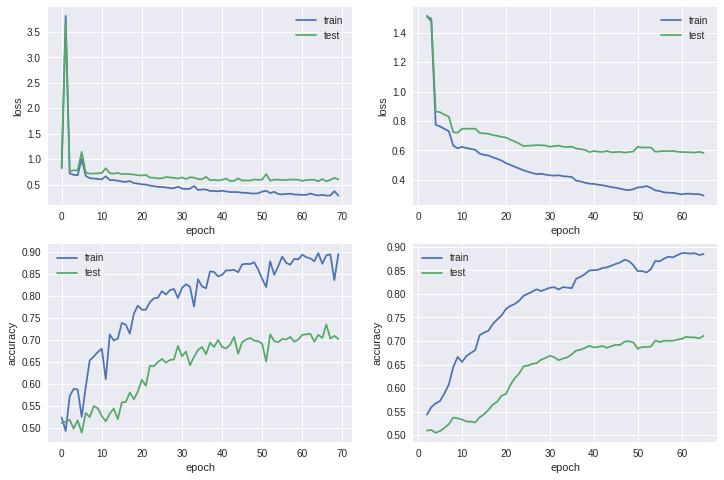

In [27]:
def smoothing(record, smoothingRadius):
  if record.shape[0] > 2 * smoothingRadius :
    record_smooth = np.zeros((record.shape[0] - (2 * smoothingRadius), record.shape[1]))
    
    for i in range(record_smooth.shape[0]):
      for j in range(record_smooth.shape[1]):
        record_smooth[i,j] = record[i-2:i+2,j].mean()
  
  return record_smooth
      

loss_smooth = smoothing(loss_rec, 2)
accuracy_smooth = smoothing(accuracy_rec, 2)


import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.subplot(221)
plt.plot(loss_rec)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(handles, ['train', 'test'])

plt.subplot(222)
plt.plot(loss_smooth)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(handles, ['train', 'test'])

plt.subplot(223)
plt.plot(accuracy_rec)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(handles, ['train', 'test'])

plt.subplot(224)
handles = plt.plot(accuracy_smooth)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(handles, ['train', 'test'])

plt.show()